# Testing Stock Fetcher 

## Imports 

In [1]:
# Reload Custom Modules 
import importlib
import src.beta_vae
import src.data_fetching 
import src.portfolio
importlib.reload(src.beta_vae)
importlib.reload(src.data_fetching)
importlib.reload(src.portfolio)

<module 'src.portfolio' from 'c:\\Users\\jairp\\OneDrive\\Desktop_remote\\HEC Montreal\\4. Fall 2024\\Deep Learning II\\Project\\StockDiversifier\\src\\portfolio.py'>

In [2]:
# General 
import os 
import json 
import random 
from tqdm.notebook import tqdm

# Data Science
import optuna 
import numpy as np 
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# PyTorch
import torch

# Custom Classes 
from src.beta_vae import Encoder
from src.beta_vae import Decoder
from src.beta_vae import BetaVAE
from src.portfolio import Portfolio

# Custom Functions
from src.beta_vae import create_data_loaders
from src.beta_vae import create_single_data_loader
from src.beta_vae import objective
from src.beta_vae import train_beta_vae
from src.beta_vae import get_embeddings
from src.beta_vae import generate_embeddings_dict
from src.portfolio import fetch_and_calculate_returns
from src.portfolio import diversify_betavae_portfolio
from src.data_fetching import scrape_sp500_wikipedia
from src.data_fetching import fetch_stock_data
from src.data_fetching import prepare_data_for_vae

In [3]:
custom_tickers = [
    'PLTR',  # Palantir Technologies Inc. (Technology)
    'COIN',  # Coinbase Global, Inc. (Financials)
    'WDAY',  # Workday, Inc. (Technology)
    'TTD',   # The Trade Desk, Inc. (Technology)
    'APO',   # Apollo Global Management, Inc. (Financials)
    'MELI',  # MercadoLibre, Inc. (Consumer Discretionary)
    'NVO',   # Novo Nordisk A/S (Healthcare)
    'ICON',  # Icon PLC (Healthcare)
    'TSM',   # Taiwan Semiconductor Manufacturing Company Limited (Technology)
    'SKX',   # Skechers U.S.A., Inc. (Consumer Discretionary)
    'BAYRY', # Bayer AG (Healthcare)
    'DISCK', # Discovery, Inc. (Communication Services)
    'FNV',   # Franco-Nevada Corporation (Materials)
    'SHOP',  # Shopify Inc. (Technology)
    'SQ',    # Square, Inc. (Technology)
    'UBER',  # Uber Technologies, Inc. (Industrials)
    'ZM',    # Zoom Video Communications, Inc. (Technology)
    'TWLO',  # Twilio Inc. (Technology)
    'MRNA',  # Moderna, Inc. (Healthcare)
    'WDAY',  # Workday, Inc. (Technology)
    'DOCU',  # DocuSign, Inc. (Technology)
    'VEEV',  # Veeva Systems Inc. (Healthcare)
    'LULU',  # Lululemon Athletica Inc. (Consumer Discretionary)
    'ROKU',  # Roku, Inc. (Communication Services)
    'CRWD',  # CrowdStrike Holdings, Inc. (Technology)
    'SNOW',  # Snowflake Inc. (Technology)
    'NET',   # Cloudflare, Inc. (Technology)
    'PINS',  # Pinterest, Inc. (Communication Services)
    'ETSY',  # Etsy, Inc. (Consumer Discretionary)
    'SPOT'   # Spotify Technology S.A. (Communication Services)
]

## Fetching the data 

In [4]:
# Convert ndarray values to lists for JSON serialization
def serialize_ndarray(data_dict):
    return {key: (value.tolist() if isinstance(value, np.ndarray) else value) for key, value in data_dict.items()}

# Convert lists back to ndarrays if needed
def deserialize_ndarray(data_dict):
    return {key: (np.array(value) if isinstance(value, list) else value) for key, value in data_dict.items()}

In [5]:
REFETCH = True 
LOAD_RETURNS = False 

############################################################################################
### Step 1: Scrape SP500 

# Scrape S&P 500 companies names, tikers and industris from Wikipedia
sp500_df = scrape_sp500_wikipedia()  

############################################################################################
## Step 2: Fetch Stock Data Features 

if REFETCH:
    # Fetch data for all sp500 + custom tickers
    stock_data, sector_mapping, industry_mapping = fetch_stock_data(sp500_df, custom_tickers, 
                                                                    period = "1y", interval = "1wk",
                                                                    savepath="data_raw/stock_data.csv") # Fetch data
else: 
    # read data from file
    stock_data = pd.read_csv("data_raw/stock_data.csv", index_col=0).reset_index()


############################################################################################
## Step 3: Fetch Returns for all tickers

if LOAD_RETURNS:
    # Load the returns from the file
    with open("data_raw/all_returns.json", "r") as f:
        all_returns = json.load(f)

    # Deserialize loaded data
    all_returns = deserialize_ndarray(all_returns)

    # Show the first few tickers and their returns
    print("First few tickers and their returns:")
    for ticker, returns in list(all_returns.items())[:5]:
        print(f"{ticker}: {returns[:5]}...")  # Print first 5 returns for each ticker

else: 
    # Fetch and calculate returns for the all tickers in the S&P 500 and additional tickers
    all_tickers = stock_data["Ticker"].values.tolist()  # All S&P 500 tickers
    print(f"number of tickers: {len(all_tickers)}")

    # Fetch and calculate returns for all tickers
    all_returns = fetch_and_calculate_returns(all_tickers, period="1y", interval="1wk", price_column="Close")

    # Find the mode of the lengths of the returns among all tickers
    return_lengths = [len(returns) for returns in all_returns.values()]
    return_length_mode = max(set(return_lengths), key=return_lengths.count)

    # Ensure to keep only the returns with the mode length and report the discarded tickers 
    discarded_tickers = [ticker for ticker, returns in all_returns.items() if len(returns) != return_length_mode]
    all_returns = {ticker: returns for ticker, returns in all_returns.items() if len(returns) == return_length_mode}
    print(f"Discarded tickers with inconsistent return lengths: {discarded_tickers}")

    # Remove from stock_data the tickers with inconsistent return lengths
    stock_data = stock_data[stock_data["Ticker"].isin(all_returns.keys())].reset_index().drop(columns=["index"])

    print("Total number of tickers with consistent return lengths:", len(all_returns))
    print("stock_date shape:", stock_data.shape)

    # Save the dictionary with the returns to a file using json 
    with open("data_raw/all_returns.json", "w") as f:
        print(f"Saving returns to {f.name}")
        json.dump(serialize_ndarray(all_returns), f, indent=4)

############################################################################################
## Step 4: Prepare Data for VAE	

# Prepare data for VAE
stock_data_vae = prepare_data_for_vae(stock_data) 

Fetching stock data...:   3%|▎         | 15/527 [00:11<05:34,  1.53it/s]ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
Fetching stock data...:  43%|████▎     | 224/527 [02:27<03:22,  1.49it/s]SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
Fetching stock data...:  43%|████▎     | 228/527 [02:29<03:12,  1.56it/s]$BRK.B: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$BRK.B: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
Fetching stock data...:  50%|█████     | 264/527 [02:57<03:02,  1.44it/s]$DISCK: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be deli

Completed fetching stock data in 357.50 seconds.
saving data to data_raw/stock_data.csv
521


Fetching Data: 100%|██████████| 521/521 [01:49<00:00,  4.74ticker/s]


Discarded tickers with inconsistent return lengths: ['GEV', 'SOLV']
Total number of tickers with consistent return lengths: 519
stock_date shape: (519, 18)
Saving returns to data_raw/all_returns.json


In [6]:
# Show one example return series
print("Returns for AAPL:")
print(all_returns["AAPL"])

Returns for AAPL:
[ 0.02337371  0.00950388 -0.02009418 -0.00552697 -0.05895183  0.0261619
  0.03033562  0.00448936 -0.03414395  0.01614209 -0.03339887  0.00115189
 -0.0156695  -0.04970495  0.01107007 -0.00196974 -0.00464353 -0.01108006
  0.04110163 -0.06542058  0.02606062  0.08316597 -0.00179963  0.03866457
  0.00057929  0.01194867  0.02413527  0.07923203 -0.02353049  0.01508496
  0.0746368   0.01855617 -0.02702351 -0.02830899  0.00871714 -0.01646491
  0.04536618  0.00465631  0.00952219 -0.0357205   0.00760797  0.02561793
 -0.00179665 -0.00434609  0.00330688  0.03274001 -0.01527655 -0.03673136
  0.01816883 -0.00754524  0.02164442  0.01305086]


In [7]:
stock_data.head()

,Ticker,Company Name,Market Cap,Sector,Industry,Open Price,Close Price,High Price,Low Price,Last Close,52 Week High,52 Week Low,Last Month Volatility,52 Week Volatility,Yearly Dividend Rate,Last Year Return Rate,Sector_encoded,Industry_encoded
0,DD,"DuPont de Nemours, Inc.",3.528794e+10,Materials,Specialty Chemicals,77.038082,77.313302,90.059998,60.248079,84.430000,90.059998,60.248079,0.231583,0.258459,1.52,0.209138,0,0
1,TRV,"The Travelers Companies, Inc.",5.930190e+10,Financials,Insurance - Property & Casualty,216.863427,218.299859,269.559998,172.513577,261.220001,269.559998,172.513593,0.214974,0.229661,4.20,0.491056,1,1
2,HWM,Howmet Aerospace Inc.,4.706127e+10,Industrials,Aerospace & Defense,78.225204,79.327869,119.279999,51.313220,115.839996,119.279999,51.313224,0.308438,0.339404,0.32,1.208170,2,2
3,DUK,Duke Energy Corporation,8.883542e+10,Utilities,Utilities - Regulated Electric,101.052231,101.525018,120.105205,86.632597,115.000000,120.105201,86.632591,0.157446,0.163377,4.18,0.316350,3,3
4,DLTR,"Dollar Tree, Inc.",1.500214e+10,Consumer Staples,Discount Stores,109.591509,108.522075,151.220001,60.490002,69.779999,151.220001,60.490002,0.363713,0.409251,0.00,-0.400258,4,4


In [8]:
# Display the data 
print(stock_data_vae.head())

     Market Cap  Open Price  Close Price  High Price   Low Price  Last Close  \
0  3.528794e+10   77.038082    77.313302   90.059998   60.248079   84.430000   
1  5.930190e+10  216.863427   218.299859  269.559998  172.513577  261.220001   
2  4.706127e+10   78.225204    79.327869  119.279999   51.313220  115.839996   
3  8.883542e+10  101.052231   101.525018  120.105205   86.632597  115.000000   
4  1.500214e+10  109.591509   108.522075  151.220001   60.490002   69.779999   

   52 Week High  52 Week Low  Last Month Volatility  52 Week Volatility  ...  \
0     90.059998    60.248079               0.231583            0.258459  ...   
1    269.559998   172.513593               0.214974            0.229661  ...   
2    119.279999    51.313224               0.308438            0.339404  ...   
3    120.105201    86.632591               0.157446            0.163377  ...   
4    151.220001    60.490002               0.363713            0.409251  ...   

   Industry_Travel Services  Industry_

In [9]:
# Print number of columns for stock_data 
print(len(stock_data.columns))

# Print number of columns in total 
print(len(stock_data_vae.columns))

# Print total number of rows 
print(len(stock_data_vae))

# Print the data types of the columns
print(stock_data_vae.dtypes)

18
145
519
Market Cap                              float64
Open Price                              float64
Close Price                             float64
High Price                              float64
Low Price                               float64
                                         ...   
Industry_Utilities - Regulated Gas      float64
Industry_Utilities - Regulated Water    float64
Industry_Utilities - Renewable          float64
Industry_Waste Management               float64
Industry_Other                          float64
Length: 145, dtype: object


In [10]:
print(stock_data_vae.columns)

Index(['Market Cap', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Last Close', '52 Week High', '52 Week Low', 'Last Month Volatility',
       '52 Week Volatility',
       ...
       'Industry_Travel Services', 'Industry_Trucking',
       'Industry_Utilities - Diversified',
       'Industry_Utilities - Independent Power Producers',
       'Industry_Utilities - Regulated Electric',
       'Industry_Utilities - Regulated Gas',
       'Industry_Utilities - Regulated Water',
       'Industry_Utilities - Renewable', 'Industry_Waste Management',
       'Industry_Other'],
      dtype='object', length=145)


### Check for any NA's

In [11]:
# Check if any columns have nas
print(stock_data_vae.isna().sum().sum())

# Produce a list of columns with nas, and the amount for each 
print(stock_data_vae.columns[stock_data_vae.isna().any()].tolist())

# Calculate the proportion of nas in the stock_data_vae dataframe for each column with nas 
# only for the columns with nas
nas_proportion = stock_data_vae.isna().mean()
print(nas_proportion[stock_data_vae.columns[stock_data_vae.isna().any()].tolist()])

0
[]
Series([], dtype: float64)


## Fitting the $\beta$-VAE

### Data Preparation

In [12]:
# Normalize the stock data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(stock_data_vae)

# Convert the normalized data to PyTorch tensors
tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(tensor_data)

# Check the DataLoader output
next(iter(train_loader))[0].shape  # Shape of one batch of data

torch.Size([64, 145])

### Hyperparameter Tunning

In [13]:
# Define the file path for storing the best parameters
best_params_file = "config/best_params.json"

REWRITE = True 
if REWRITE:
    # Delete previous best_params file
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

# Check if the best_params file exists
if os.path.exists(best_params_file):
    # Load the best parameters from the file
    with open(best_params_file, "r") as f:
        best_params = json.load(f)
    print("Loaded best parameters from file:", best_params)
    
else:
    # File doesn't exist, run the Optuna study
    print("Best parameters file not found. Running Optuna study...")
    
    # Assuming `normalized_data` is the prepared dataset
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, normalized_data, verbose=False), n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params
    print("Best hyperparameters found:", best_params)

    # Save the best parameters to a JSON file
    os.makedirs(os.path.dirname(best_params_file), exist_ok=True)  # Create directory if it doesn't exist
    with open(best_params_file, "w") as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {best_params_file}")

[I 2024-11-25 22:07:12,954] A new study created in memory with name: no-name-df38e7ac-af19-4580-ad53-2cfd6eaf8039


Best parameters file not found. Running Optuna study...


[I 2024-11-25 22:07:19,630] Trial 0 finished with value: 145.97075962035123 and parameters: {'latent_dim': 10, 'beta': 2.2347775253630706, 'learning_rate': 0.00041331522110390996, 'batch_size': 128}. Best is trial 0 with value: 145.97075962035123.
[I 2024-11-25 22:07:20,309] Trial 1 finished with value: 145.12254110709367 and parameters: {'latent_dim': 5, 'beta': 9.759454794382034, 'learning_rate': 0.003345557974916469, 'batch_size': 128}. Best is trial 1 with value: 145.12254110709367.
[I 2024-11-25 22:07:21,124] Trial 2 finished with value: 145.50009684917356 and parameters: {'latent_dim': 20, 'beta': 5.647223857244475, 'learning_rate': 0.00048542320314487973, 'batch_size': 128}. Best is trial 1 with value: 145.12254110709367.
[I 2024-11-25 22:07:22,500] Trial 3 finished with value: 145.11014979338842 and parameters: {'latent_dim': 20, 'beta': 5.996741659429749, 'learning_rate': 0.0035935484832736913, 'batch_size': 64}. Best is trial 3 with value: 145.11014979338842.
[I 2024-11-25 22

Best hyperparameters found: {'latent_dim': 20, 'beta': 4.725030215170999, 'learning_rate': 0.0007252634381091751, 'batch_size': 32}
Best parameters saved to config/best_params.json


### Model Training

In [14]:

# File path for the saved model
model_path = "models/beta_vae_with_metadata.pth"

RETRAIN = True
if RETRAIN:
    # Delete previous model file
    if os.path.exists(model_path):
        os.remove(model_path)

# Check if the model file exists
if os.path.exists(model_path):
    print(f"Model found at {model_path}. Loading the model...")

    # Load model state and metadata
    model_metadata = torch.load(model_path)

    # Recreate the model using the saved metadata
    beta_vae = BetaVAE(
        input_dim=model_metadata["input_dim"],
        latent_dim=model_metadata["latent_dim"],
        beta=model_metadata["beta"]
    )
    beta_vae.load_state_dict(model_metadata["model_state"])
    beta_vae.eval()  # Set the model to evaluation mode
    print("Model loaded successfully.")
else:
    print(f"Model not found at {model_path}. Training a new model...")

    # Assuming you use the best hyperparameters from Optuna
    latent_dim = best_params['latent_dim']
    beta = best_params['beta']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    input_dim = stock_data_vae.shape[1]

    # Recreate DataLoaders with the best batch size
    train_loader, val_loader, test_loader = create_data_loaders(tensor_data, batch_size=batch_size)

    # Initialize and train the model
    beta_vae = BetaVAE(input_dim=input_dim, latent_dim=latent_dim, beta=beta)
    train_beta_vae(beta_vae, train_loader, val_loader, num_epochs=50, learning_rate=learning_rate)

    # Save the trained model with metadata
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Ensure the directory exists
    model_metadata = {
        "model_state": beta_vae.state_dict(),
        "input_dim": input_dim,
        "latent_dim": latent_dim,
        "beta": beta
    }
    torch.save(model_metadata, model_path)
    print(f"Model trained and saved to {model_path}.")

Model not found at models/beta_vae_with_metadata.pth. Training a new model...
Epoch [1/50], Training Loss: 170.0369
Epoch [1/50], Validation Loss: 155.8955
Epoch [2/50], Training Loss: 147.5854
Epoch [2/50], Validation Loss: 149.2873
Epoch [3/50], Training Loss: 145.1697
Epoch [3/50], Validation Loss: 149.0133
Epoch [4/50], Training Loss: 145.1297
Epoch [4/50], Validation Loss: 149.0104
Epoch [5/50], Training Loss: 145.1160
Epoch [5/50], Validation Loss: 148.9810
Epoch [6/50], Training Loss: 145.1120
Epoch [6/50], Validation Loss: 148.9853
Epoch [7/50], Training Loss: 145.1030
Epoch [7/50], Validation Loss: 148.9827
Epoch [8/50], Training Loss: 145.1022
Epoch [8/50], Validation Loss: 148.9843
Epoch [9/50], Training Loss: 145.1053
Epoch [9/50], Validation Loss: 148.9867
Epoch [10/50], Training Loss: 145.1037
Epoch [10/50], Validation Loss: 148.9835
Epoch [11/50], Training Loss: 145.1063
Epoch [11/50], Validation Loss: 148.9987
Epoch [12/50], Training Loss: 145.0943
Epoch [12/50], Valida

### Extract Embeddings for Train/Val/Test Data 

In [15]:
# Extract embeddings for the training data
train_embeddings = get_embeddings(beta_vae, train_loader)

# Optionally, extract embeddings for validation and test data
val_embeddings = get_embeddings(beta_vae, val_loader)
test_embeddings = get_embeddings(beta_vae, test_loader)

print("Train Embeddings Shape:", train_embeddings.shape)  # Should be (num_samples, latent_dim)
print("Val Embeddings Shape:", val_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)
print("Total number of embeddings:", train_embeddings.shape[0] + val_embeddings.shape[0] + test_embeddings.shape[0])

Train Embeddings Shape: torch.Size([363, 20])
Val Embeddings Shape: torch.Size([78, 20])
Test Embeddings Shape: torch.Size([78, 20])
Total number of embeddings: 519


### Extract Embeddings from the Stock Data 

In [16]:
# Generate embeddings for the stock data
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Display the embeddings for the first stock
print(f"Embeddings for the first stock ({stock_data['Ticker'].iloc[0]}):")
print(stock_embeddings[stock_data["Ticker"].iloc[0]])

Embeddings for the first stock (DD):
[-0.7480039   1.5925266  -1.4871019  -1.6829982   0.19092175  0.66405153
 -0.4560815  -1.808379   -0.3604437   0.29158437  0.48262197  0.22627074
  1.3980687   0.7447007  -0.7044692  -1.3931954   0.22572625  0.46379638
  0.51798165  0.21481381]


### Building the Recommendation Function 

#### Building the Portfolio

Portfolio Summary:
Tickers: ['NVR', 'ROK', 'MTB', 'MAS', 'MOS', 'WFC', 'CBOE', 'HAS', 'TJX', 'AIZ', 'APO', 'NWS', 'EBAY', 'CMG', 'PODD', 'SNA', 'ESS', 'SBAC', 'ETN', 'HPQ']
Weights: {'NVR': 0.05, 'ROK': 0.05, 'MTB': 0.05, 'MAS': 0.05, 'MOS': 0.05, 'WFC': 0.05, 'CBOE': 0.05, 'HAS': 0.05, 'TJX': 0.05, 'AIZ': 0.05, 'APO': 0.05, 'NWS': 0.05, 'EBAY': 0.05, 'CMG': 0.05, 'PODD': 0.05, 'SNA': 0.05, 'ESS': 0.05, 'SBAC': 0.05, 'ETN': 0.05, 'HPQ': 0.05}
Portfolio Expected Return: 0.006643392517812372
Portfolio Volatility: 0.017190250710572758
Portfolio Diversification Ratio: 2.024332677292119
Portfolio Sharpe Ratio: 0.38646280555561613


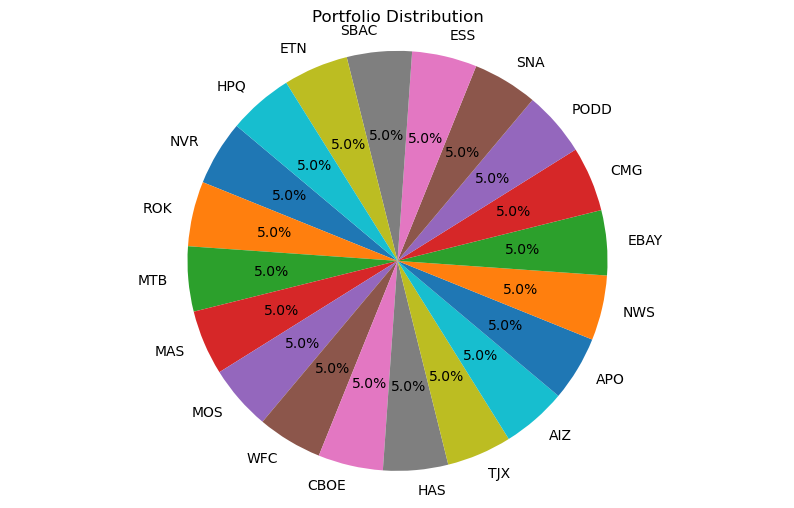

In [21]:
# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 20, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Obtain a summary of the portfolio 
random_portfolio.summarize_portfolio()

# Visualize portfolio distribution 
random_portfolio.visualize_portfolio_distribution()


#### Optimizing the Portfolio 


--- Portfolio Summary After Optimization ---
Portfolio Summary:
Tickers: ['NVR', 'ROK', 'MTB', 'MAS', 'MOS', 'WFC', 'CBOE', 'HAS', 'TJX', 'AIZ', 'APO', 'NWS', 'EBAY', 'CMG', 'PODD', 'SNA', 'ESS', 'SBAC', 'ETN', 'HPQ']
Weights: {'NVR': 0.0007271641771118926, 'ROK': 0.006238567923732243, 'MTB': 3.6546634362556214e-16, 'MAS': 0.0213551580568235, 'MOS': 0.09250786304838339, 'WFC': 0.12566457464960065, 'CBOE': 0.2391147567922457, 'HAS': 0.009835850647698603, 'TJX': 5.4087247683099236e-17, 'AIZ': 2.335492000563955e-17, 'APO': 0.02445551490565913, 'NWS': 0.006620169200881108, 'EBAY': 0.02355220493775037, 'CMG': 0.216879373568095, 'PODD': 0.08709269342282934, 'SNA': 5.955792454061385e-16, 'ESS': 3.46531426443689e-16, 'SBAC': 0.11997508420475639, 'ETN': 2.3595981475838973e-16, 'HPQ': 0.025981024464431603}
Portfolio Expected Return: 0.004919340449538321
Portfolio Volatility: 0.012969744439383694
Portfolio Diversification Ratio: 2.8005446874716324
Portfolio Sharpe Ratio: 0.37929355297089273


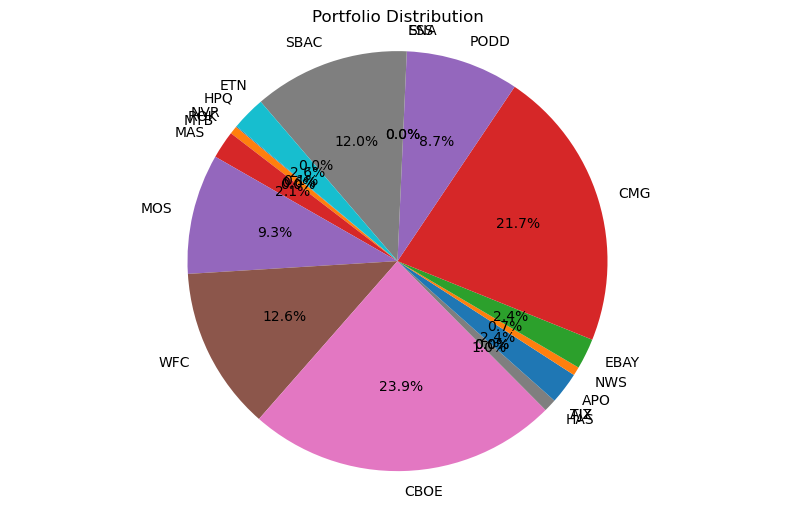

In [22]:
# Optimize portfolio weights 
random_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the portfolio after optimization
print("\n--- Portfolio Summary After Optimization ---")
random_portfolio.summarize_portfolio()

# Visualize the portfolio distribution after optimization
random_portfolio.visualize_portfolio_distribution()

#### Extracting Portfolio Embeddings

In [37]:
# Define Optim method for both portfolios 
optim_method = "max_div"

# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 15, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Optimize portfolio weights 
random_portfolio.optimize_weights(method=optim_method, update_weights=True)

# Generate embeddings for the stock data (full universe of data)
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Extract embeddings from Portfolio  
random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                               if ticker in stock_embeddings.keys()}

# Check that number of extracted embeddings == number of portfolio tickers
assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)

# Apply the diversify function to the random portfolio
updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
    portfolio = random_portfolio,
    portfolio_embeddings = random_portfolio_embeddings,
    all_returns = all_returns,
    all_stock_embeddings = stock_embeddings,
    num_iter=200, # number of iterations for the optimization algorithm
    top_N=5, # num top most dissimilar assets to consider for swapping
    optim_algorithm=optim_method,
    distance_type="euclidean"
)

# Print the final diversification ratio and the swap log
print("\nFinal Diversification Ratio:", updated_portfolio.diversification_ratio)
print("Diversification History:", diversification_history)
print("Swap Log (Removed -> Added):", swap_log)


Initial Diversification Ratio: 2.667425190261757


Diversification Iterations:   4%|▍         | 9/200 [00:00<00:02, 80.95it/s]

Accepted Swap: TYL -> COR
New Diversification Ratio: 2.7319598337113904
Accepted Swap: IR -> PNC
New Diversification Ratio: 2.7332425290876317
Accepted Swap: DHR -> GOOGL
New Diversification Ratio: 3.123633232872403
Accepted Swap: INTC -> VRSK
New Diversification Ratio: 3.1332528057946725
Accepted Swap: ACGL -> MPC
New Diversification Ratio: 3.1601204820513926
Accepted Swap: ON -> MRNA
New Diversification Ratio: 3.28978043200347
Accepted Swap: CNC -> HST
New Diversification Ratio: 3.291313570342713
Accepted Swap: IRM -> EIX
New Diversification Ratio: 3.295068225811856


Diversification Iterations:   9%|▉         | 18/200 [00:00<00:02, 75.78it/s]

Accepted Swap: MS -> PFE
New Diversification Ratio: 3.364206212035423


Diversification Iterations:  14%|█▎        | 27/200 [00:00<00:02, 77.73it/s]

Accepted Swap: DOV -> PFG
New Diversification Ratio: 3.364206566540102


Diversification Iterations: 100%|██████████| 200/200 [00:03<00:00, 62.81it/s]


Final Diversification Ratio: 3.364206566540102
Diversification History: [2.667425190261757, 2.7319598337113904, 2.7332425290876317, 3.123633232872403, 3.1332528057946725, 3.1601204820513926, 3.28978043200347, 3.291313570342713, 3.295068225811856, 3.364206212035423, 3.364206566540102]
Swap Log (Removed -> Added): {'TYL': 'COR', 'IR': 'PNC', 'DHR': 'GOOGL', 'INTC': 'VRSK', 'ACGL': 'MPC', 'ON': 'MRNA', 'CNC': 'HST', 'IRM': 'EIX', 'MS': 'PFE', 'DOV': 'PFG'}


In [38]:
print("\n--- Original Portfolio ---")
# Summarize the original random portfolio
random_portfolio.summarize_portfolio()

print("\n--- Updated Portfolio ---")

# Optimize the updated portfolio weights with max_div 
updated_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the updated portfolio
updated_portfolio.summarize_portfolio()


--- Original Portfolio ---
Portfolio Summary:
Tickers: ['TYL', 'STZ', 'DHR', 'HD', 'IRM', 'F', 'CNC', 'DOV', 'INTC', 'CME', 'ON', 'IR', 'ACGL', 'PM', 'MS']
Weights: {'TYL': 0.021486839090748912, 'STZ': 0.13020290181140323, 'DHR': 0.051263596139570294, 'HD': 0.050102351571346224, 'IRM': 6.884683795282953e-17, 'F': 0.10575385212499423, 'CNC': 0.04606771632428592, 'DOV': 0.0, 'INTC': 0.0, 'CME': 0.24786805667298956, 'ON': 0.03968926263726505, 'IR': 0.02018163610143974, 'ACGL': 0.0779427315921949, 'PM': 0.2094410559337619, 'MS': 1.1563016169557905e-16}
Portfolio Expected Return: 0.0036627240526349207
Portfolio Volatility: 0.011348287692518824
Portfolio Diversification Ratio: 2.667425190261757
Portfolio Sharpe Ratio: 0.3227556572300782

--- Updated Portfolio ---
Portfolio Summary:
Tickers: ['STZ', 'HD', 'F', 'CME', 'PM', 'COR', 'PNC', 'GOOGL', 'VRSK', 'MPC', 'MRNA', 'HST', 'EIX', 'PFE', 'PFG']
Weights: {'STZ': 0.032165395094676676, 'HD': 0.11104832355243034, 'F': 0.026645763601037216, 'CME

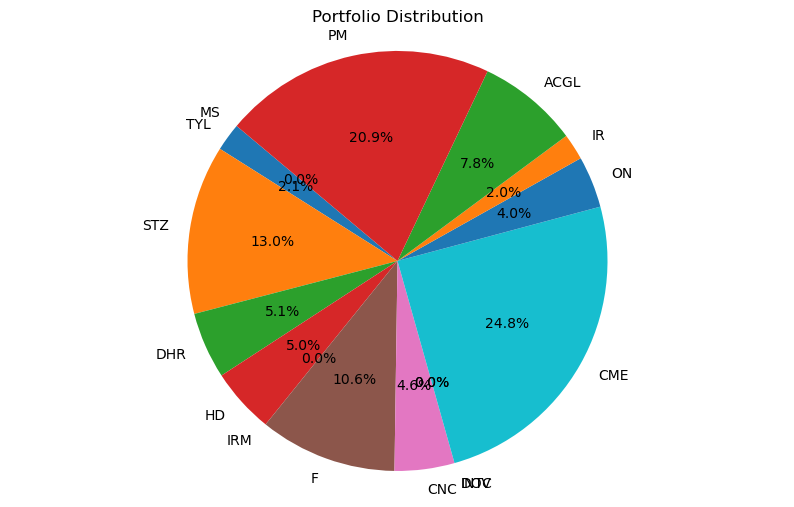

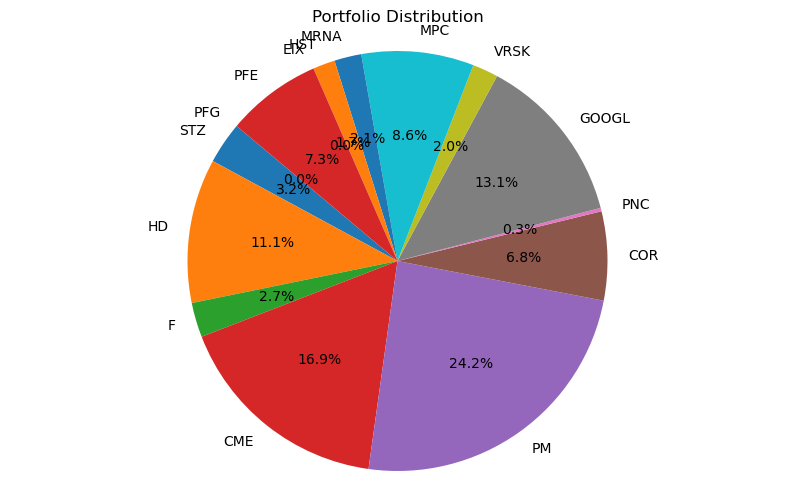

In [39]:
random_portfolio.visualize_portfolio_distribution()
updated_portfolio.visualize_portfolio_distribution()

## Implementing the Full Experiment 

In [ ]:
# Initialize storage for portfolio results
portfolio_results = []
portfolio_tickers = {}

# Define number of iterations for diversification process
num_portfolios = 15
num_initial_tickers = 15
optim_method = "max_div"

for i in range(1, num_portfolios + 1):
    # Step 1: Generate random portfolio
    random_tickers = np.random.choice(list(all_returns.keys()), num_initial_tickers, replace=False)
    random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}
    random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")
    
    # Optimize initial portfolio
    random_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
    # Record initial DR and SR
    initial_dr = random_portfolio.diversification_ratio
    initial_sr = random_portfolio.sharpe_ratio
    
    # Step 2: Generate embeddings
    random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                                   if ticker in stock_embeddings.keys()}
    assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)
    
    # Step 3: Apply diversification function
    updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
        portfolio=random_portfolio,
        portfolio_embeddings=random_portfolio_embeddings,
        all_returns=all_returns,
        all_stock_embeddings=stock_embeddings,
        num_iter=200,
        top_N=5,
        optim_algorithm=optim_method,
        distance_type="euclidean"
    )
    
    # Optimize the updated portfolio after swaps
    updated_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
    # Record updated DR and SR
    final_dr = updated_portfolio.diversification_ratio
    final_sr = updated_portfolio.sharpe_ratio
    
    # Store tickers for the updated portfolio
    portfolio_tickers[f"Portfolio_{i}"] = updated_portfolio.tickers
    
    # Save results for the dataframe
    portfolio_results.append({
        "Portfolio": f"Portfolio_{i}",
        "Initial_DR": initial_dr,
        "Final_DR": final_dr,
        "Initial_SR": initial_sr,
        "Final_SR": final_sr, 
        "Tickers": updated_portfolio.tickers
    })

# Convert results to a DataFrame
portfolio_results_df = pd.DataFrame(portfolio_results)

# Sort by Final_DR
portfolio_results_df = portfolio_results_df.sort_values(by="Final_DR", ascending=False)


Initial Diversification Ratio: 2.2266897482284143


Diversification Iterations:   4%|▎         | 7/200 [00:00<00:03, 62.68it/s]

Accepted Swap: AKAM -> MKC
New Diversification Ratio: 2.2432277051112055
Accepted Swap: TMO -> V
New Diversification Ratio: 2.3532880652543873
Accepted Swap: AMAT -> MPC
New Diversification Ratio: 2.4566601097339524
Accepted Swap: ZBRA -> KEYS
New Diversification Ratio: 2.4566606563564495
Accepted Swap: EQR -> ZTS
New Diversification Ratio: 2.465642731922364
Accepted Swap: FITB -> GOOGL
New Diversification Ratio: 2.5348675393037117
Accepted Swap: GNRC -> LNT
New Diversification Ratio: 2.787724396101872
Accepted Swap: KIM -> EIX
New Diversification Ratio: 2.795413455191586
Accepted Swap: CBRE -> PYPL
New Diversification Ratio: 2.799098423051025
Accepted Swap: ZTS -> VRSK
New Diversification Ratio: 2.8399862234954893
Accepted Swap: KMB -> MRNA
New Diversification Ratio: 2.9934474220726695


Diversification Iterations:  14%|█▎        | 27/200 [00:00<00:03, 55.62it/s]

Accepted Swap: LRCX -> TPL
New Diversification Ratio: 2.9971253010501173
Accepted Swap: TPL -> CPB
New Diversification Ratio: 3.0997343893342624


Diversification Iterations:  23%|██▎       | 46/200 [00:00<00:02, 54.52it/s]

Accepted Swap: ABT -> CAH
New Diversification Ratio: 3.127335535987255
Accepted Swap: OKE -> PFG
New Diversification Ratio: 3.127335552894412
Accepted Swap: ESS -> YUM
New Diversification Ratio: 3.154344705266409


Diversification Iterations: 100%|██████████| 200/200 [00:02<00:00, 71.70it/s]


Initial Diversification Ratio: 2.1440915156641065


Diversification Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Display the table
display(portfolio_results_df)

,Portfolio,Initial_DR,Final_DR,Initial_SR,Final_SR
2,Portfolio_3,2.829927,3.570440,0.184160,0.218931
8,Portfolio_9,3.011850,3.424394,0.320273,0.407368
1,Portfolio_2,2.367748,3.298919,0.098180,0.404101
3,Portfolio_4,2.657892,3.282597,0.360599,0.508164
9,Portfolio_10,2.346814,3.183305,0.356064,0.308470
4,Portfolio_5,2.352192,3.076579,0.453263,0.492019
0,Portfolio_1,2.642394,3.021205,0.140841,0.316710
7,Portfolio_8,2.633829,2.752171,0.502540,0.486154
5,Portfolio_6,2.106945,2.719731,0.277109,0.319325
6,Portfolio_7,2.187706,2.688848,0.178903,0.363160
